In [18]:
import os.path as osp
!pip install ogb

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+${cu113}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+${cu113}.html
# !pip install torch-geometric

!pip install git+https://github.com/pyg-team/pytorch_geometric.git
# above lines come from https://stackoverflow.com/questions/68860621/ogb-dataset-i-can-not-import-pygnodeproppreddataset-from-ogb-nodeproppred/73253686#73253686?newreg=ecddaa0a5aa44fd8a4f41385db5c3e8f
import torch
import torch.nn.functional as F
import ogb

import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.nn import MaskLabel, TransformerConv
from torch_geometric.utils import index_to_mask
from ogb.nodeproppred import PygNodePropPredDataset

Looking in links: https://data.pyg.org/whl/torch-1.12.0+.html
Looking in links: https://data.pyg.org/whl/torch-1.12.0+.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /private/var/folders/27/l6v26dbx0093xg448fxvxmpc0000gn/T/pip-req-build-6oem3kt9
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /private/var/folders/27/l6v26dbx0093xg448fxvxmpc0000gn/T/pip-req-build-6oem3kt9
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit a00f2eb95c9151045f70c8ee08b73c8ca2ed2d3b
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0-py3-none-any.whl size=689687 sha256=d58b9a8547882441a5124f8a1bdd5ac5aca15c52f4234dd3c4f8376b15e2936d
  Stored in directory: /private/var/folders/27/l6v26dbx0093xg448fxvxmpc0000gn/T/pip-ephem-wheel-cache-gpenmk5w/wheels/e5/8a/bc/10228fa47bb01dd916740a9102c063c4e363e7dac6d55dba4a
Successfully built torch-geometric
  Attempting uninstall: torch-geometric
    Found existing installation: torch

In [17]:
!pwd

/Users/zhaozihan/Desktop/HEP_research/SSL-jets


In [19]:
root = osp.join(osp.dirname("/Users/zhaozihan/Desktop/HEP_research/SSL-jets"), '..', 'data', 'OGB')
dataset = PygNodePropPredDataset('ogbn-arxiv', root, T.ToUndirected())

In [3]:
class UniMP(torch.nn.Module):   #UniMP stands for Unified Message Passing
    def __init__(self, in_channels, num_classes, hidden_channels, num_layers,
                 heads, dropout=0.3):
        super().__init__()

        self.label_emb = MaskLabel(num_classes, in_channels)

        self.convs = torch.nn.ModuleList()  # initialize self.convs
        self.norms = torch.nn.ModuleList()  # initialize self.norms
        for i in range(1, num_layers + 1):
            if i < num_layers:
                out_channels = hidden_channels // heads #what is a head?
                concat = True   #what does concat do?
            else:
                out_channels = num_classes
                concat = False
            conv = TransformerConv(in_channels, out_channels, heads,
                                   concat=concat, beta=True, dropout=dropout)
            self.convs.append(conv)
            in_channels = hidden_channels

            if i < num_layers:
                self.norms.append(torch.nn.LayerNorm(hidden_channels))
                #why a separate if statement?
                
    def forward(self, x, y, edge_index, label_mask):
        x = self.label_emb(x, y, label_mask)
        for conv, norm in zip(self.convs, self.norms):
            x = norm(conv(x, edge_index)).relu()
        # conv -> norm -> ReLu -> conv -> norm -> Relu -> ... -> out
        return self.convs[-1](x, edge_index)

## Questions:  

### 2. What does emb stand for?  
Embedding

### 3. What are normalization layers?  what do they do and why do we need them?
https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html  
Normalization? but why?

### 3.1 What are heads?  

### 4. What does concat do?  
If set to False, the multi-head attentions are averaged instead of concatenated. (default: True)  

### 4.1 What are attentions?  

### 7. Why a separate if statement for self.norms?


### 8. What does each parameter mean in this function?  
x: input?  
y: output?  
edge_index: how the graph is connected  
label_mask: 

### 8.1 What does the first line do?  

In [ ]:
"""
def forward(self, x: Tensor, y: Tensor, mask: Tensor) -> Tensor:  
        """"""  
        if self.method == "concat":  
            out = x.new_zeros(y.size(0), self.emb.weight.size(-1))  
            out[mask] = self.emb(y[mask])  
            return torch.cat([x, out], dim=-1)  
        else:  
            x = torch.clone(x)  
            x[mask] += self.emb(y[mask])  
            return x
"""

I assume this applies the mask to the inputs x but why does this process involve y?  

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device)
data.y = data.y.view(-1)
model = UniMP(dataset.num_features, dataset.num_classes, hidden_channels=64,
              num_layers=3, heads=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
 
split_idx = dataset.get_idx_split()   # train/val/test split
train_mask = index_to_mask(split_idx['train'], size=data.num_nodes)
val_mask = index_to_mask(split_idx['valid'], size=data.num_nodes)
test_mask = index_to_mask(split_idx['test'], size=data.num_nodes)

##  Questions:  
### 10. What is weight_decay?  
L2 penalty  
https://swamp-father-f58.notion.site/2-3-Lecture-Dealing-with-Overfitting-f1a77a6d12f445698e4d8cb340300d88

### 12. What does the mask do?  
They mask some of the labels, preventing the nodes from accessing those labels during training/validation/testing



In [13]:
def train(label_rate=0.65):  # How many labels to use for propagation.
    model.train()

    propagation_mask = MaskLabel.ratio_mask(train_mask, ratio=label_rate)
    # Randomly modifies mask by setting ratio of True entries to False
    supervision_mask = train_mask ^ propagation_mask  # Exclusive or: Sets each bit to 1 if only one of two bits is 1
#     print("train_mask:", train_mask)
#     print("propagation_mask:", propagation_mask)
#     print("supervision_mask:", supervision_mask)

    optimizer.zero_grad()
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    loss = F.cross_entropy(out[supervision_mask], data.y[supervision_mask])
    loss.backward()
    optimizer.step()

    return float(loss)


@torch.no_grad()
def test():
    model.eval()

    propagation_mask = train_mask  #no masked nodes while testing
    out = model(data.x, data.y, data.edge_index, propagation_mask)  # forward is called
    pred = out[val_mask].argmax(dim=-1)
    val_acc = int((pred == data.y[val_mask]).sum()) / pred.size(0)  # Validation accuracy

    propagation_mask = train_mask | val_mask    #Or: Sets each bit to 1 if one of two bits is 1
    out = model(data.x, data.y, data.edge_index, propagation_mask)
    pred = out[test_mask].argmax(dim=-1)
    test_acc = int((pred == data.y[test_mask]).sum()) / pred.size(0)

    return val_acc, test_acc

## Questions:  

### 13. What is propagation_mask?  
decides which nodes to use for message passing
### 13.1 What is supervision_mask?  
decides which nodes to use for verifying predictions  
(propagation + supervision = training)
### 14. Why use exclusive OR for supervision_mask but regular OR for propagation_mask



In [14]:
num_epochs = 45
loss_lst, val_acc_lst, test_acc_lst = [], [], []

for epoch in range(1, num_epochs+1):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')
    loss_lst.append(loss)
    val_acc_lst.append(val_acc)
    test_acc_lst.append(test_acc)

Epoch: 001, Loss: 3.2076, Val: 0.5170, Test: 0.5612
Epoch: 002, Loss: 3.1502, Val: 0.5269, Test: 0.5687
Epoch: 003, Loss: 3.0901, Val: 0.5329, Test: 0.5727
Epoch: 004, Loss: 3.0348, Val: 0.5383, Test: 0.5769
Epoch: 005, Loss: 2.9913, Val: 0.5445, Test: 0.5826
Epoch: 006, Loss: 2.9361, Val: 0.5498, Test: 0.5873
Epoch: 007, Loss: 2.8838, Val: 0.5537, Test: 0.5911
Epoch: 008, Loss: 2.8326, Val: 0.5592, Test: 0.5951
Epoch: 009, Loss: 2.7856, Val: 0.5645, Test: 0.6006
Epoch: 010, Loss: 2.7340, Val: 0.5706, Test: 0.6071
Epoch: 011, Loss: 2.6934, Val: 0.5778, Test: 0.6143
Epoch: 012, Loss: 2.6458, Val: 0.5864, Test: 0.6204
Epoch: 013, Loss: 2.6014, Val: 0.5935, Test: 0.6254
Epoch: 014, Loss: 2.5538, Val: 0.5990, Test: 0.6301
Epoch: 015, Loss: 2.5063, Val: 0.6044, Test: 0.6337
Epoch: 016, Loss: 2.4762, Val: 0.6102, Test: 0.6372
Epoch: 017, Loss: 2.4274, Val: 0.6142, Test: 0.6396
Epoch: 018, Loss: 2.3811, Val: 0.6171, Test: 0.6405
Epoch: 019, Loss: 2.3446, Val: 0.6190, Test: 0.6423
Epoch: 020, 

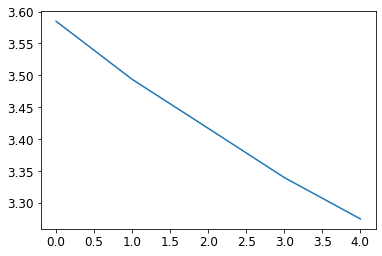

In [8]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

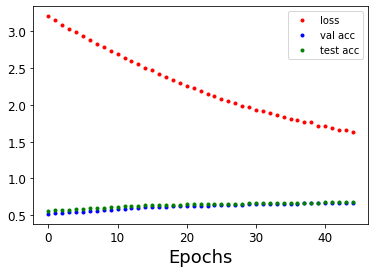

In [15]:
plt.plot(loss_lst, "r.", label="loss")
plt.plot(val_acc_lst, "b.", label="val acc")
plt.plot(test_acc_lst, "g.",label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
plt.show()

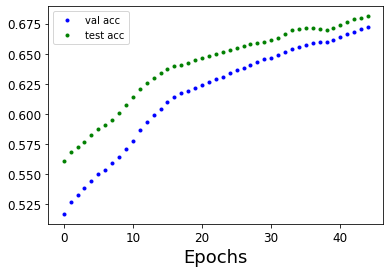

In [16]:
plt.plot(val_acc_lst, "b.", label="val acc")
plt.plot(test_acc_lst, "g.",label="test acc")
plt.xlabel("Epochs", fontsize=18)
# plt.ylabel("value of params", rotation=90, fontsize=18)
plt.legend(loc="best", fontsize=10)
plt.show()

## Try to plot the roc curve